# Frequency domain analysis
In the previous tutorial, we have seen how to extract event-related information from the time sequence. Now, we opt for a time-frequency approach to observe how the brain handles motor activity. In particular, we will explore different baseline normalization techniques and observe their differences.

In [2]:
import numpy as np
import mne
import matplotlib.pyplot as plt
%matplotlib notebook

## Description of the paradigm and goal of the analysis
In this recording, participants were presented randomly with one of two stimuli at each trial:
- Stimulus 1: a drawing of a face is presented (marker `10`)
- Stimulus 2: a number is displayed on a screen and at the same time a pure tone is played in headphones (marker `20`)

Upon presentation of these stimuli, participants had to provide a response through key press on a keyboard with their right hand (left arrow for stimulus 1 (yielding marker `110`) and right arrow for stimulus 2 (yielding marker `120`)).
In the prestimulus period, 9 frames of visual noise were presented (each lasting 100ms).

In this tutorial, we aim at observing ERDs in the alpha band (~8-13Hz), relative to the motor response.

## Import data and pre-processing

Given the description of the goal above, import the dataset we used previously, pre-process and epoch it with the techniques of your choice. You should extract a baseline too, as we will normalize the data later.

N.B.: as opposed to last tutorial, we are here interested in the motor response, not the sensory response. Make sure you are using the right markers to align your data best.

In [6]:
datapath = "D:/PhD/EEG data/face is left button_instructions/participant 115/115_bloc_1.vhdr"
eegdata = mne.io.read_raw_brainvision(datapath,preload=True)
eegdata.filter(3.,35.,)
event_id=[110,120]

events, event_dict = mne.events_from_annotations(eegdata)
evt_ix=np.where(events[:,2]==event_id[0])
for ix in range(1,len(event_id)):
    evt_ix=np.hstack((evt_ix, np.where(events[:,2]==event_id[ix])))
stim_events=np.squeeze(events[evt_ix])
stim_events=np.sort(stim_events.view('int,int,int'), order=['f1'], axis=0).view(np.int)


ep=mne.Epochs(eegdata, stim_events, event_id, tmin=-2, tmax=1, baseline=None, preload=True)

montage1020 = mne.channels.make_standard_montage('standard_1020')
ep= ep.set_montage(montage1020)
ep.info['bads'] = ['Fp1','Fp2', 'T8']
ep.pick_types(eeg=True, exclude=[])
print(ep.info)
ep.interpolate_bads(reset_bads=True)

Extracting parameters from D:/PhD/EEG data/face is left button_instructions/participant 115/115_bloc_1.vhdr...
Setting channel info structure...
Reading 0 ... 350839  =      0.000 ...   350.839 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 1651 samples (1.651 sec)

Used Annotations descriptions: ['Comment/actiCAP Data On', 'New Segment/', 'Stimulus/S 10', 'Stimulus/S 20', 'Stimulus/S 33', 'Stimulus/S 43', 'Stimulus/S 53', 'Stimulus/S110', 'Stimulus/S111', 'Stimulus/S120', 'Stimulus/S121', 'Stimul

<Epochs |  60 events (all good), -2 - 1 sec, baseline off, ~44.0 MB, data loaded,
 '110': 32
 '120': 28>

## Build the spectral components
We mentionned at the beginning of this tutorial that we want to observe motor-related activity, and that it manifests mostly by activity in the alpha band. First, extract the spectral activity in all frequency bands, using for example the function `mne.time_frequency.tfr_morlet()`. Set n_cycles=3

In [22]:
freqs=np.arange(3,35,2)
n_cycles=3

power=mne.time_frequency.tfr_morlet(ep, freqs, n_cycles,return_itc=False,average=True)
pw=mne.time_frequency.tfr_multitaper(ep, freqs, n_cycles)

You can visualize the spectrogram for channel C3.

No baseline correction applied


<IPython.core.display.Javascript object>


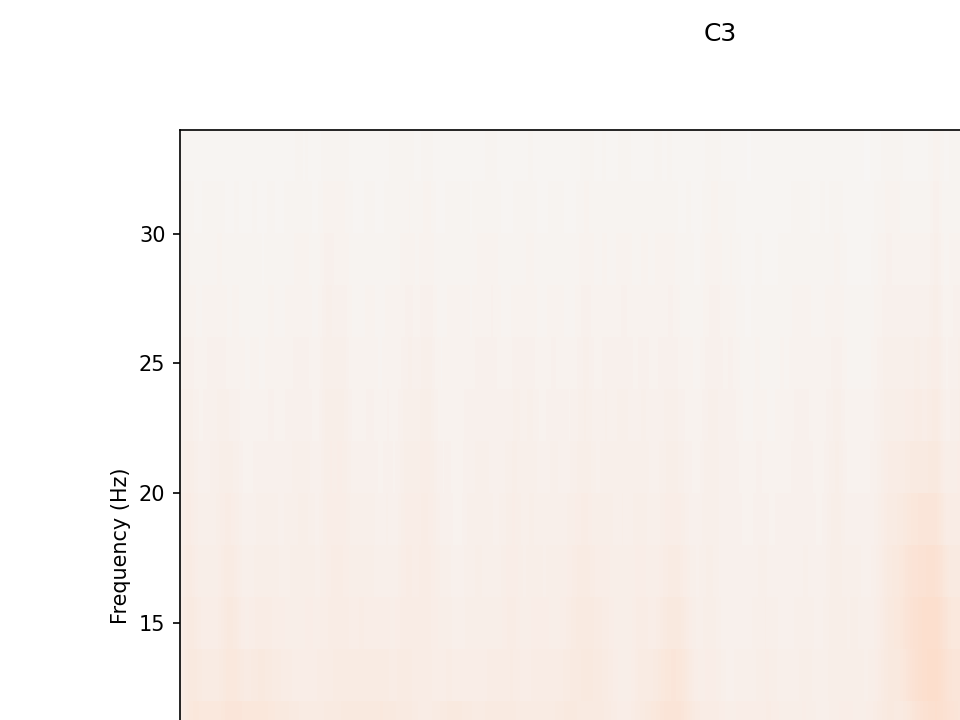

<IPython.core.display.Javascript object>


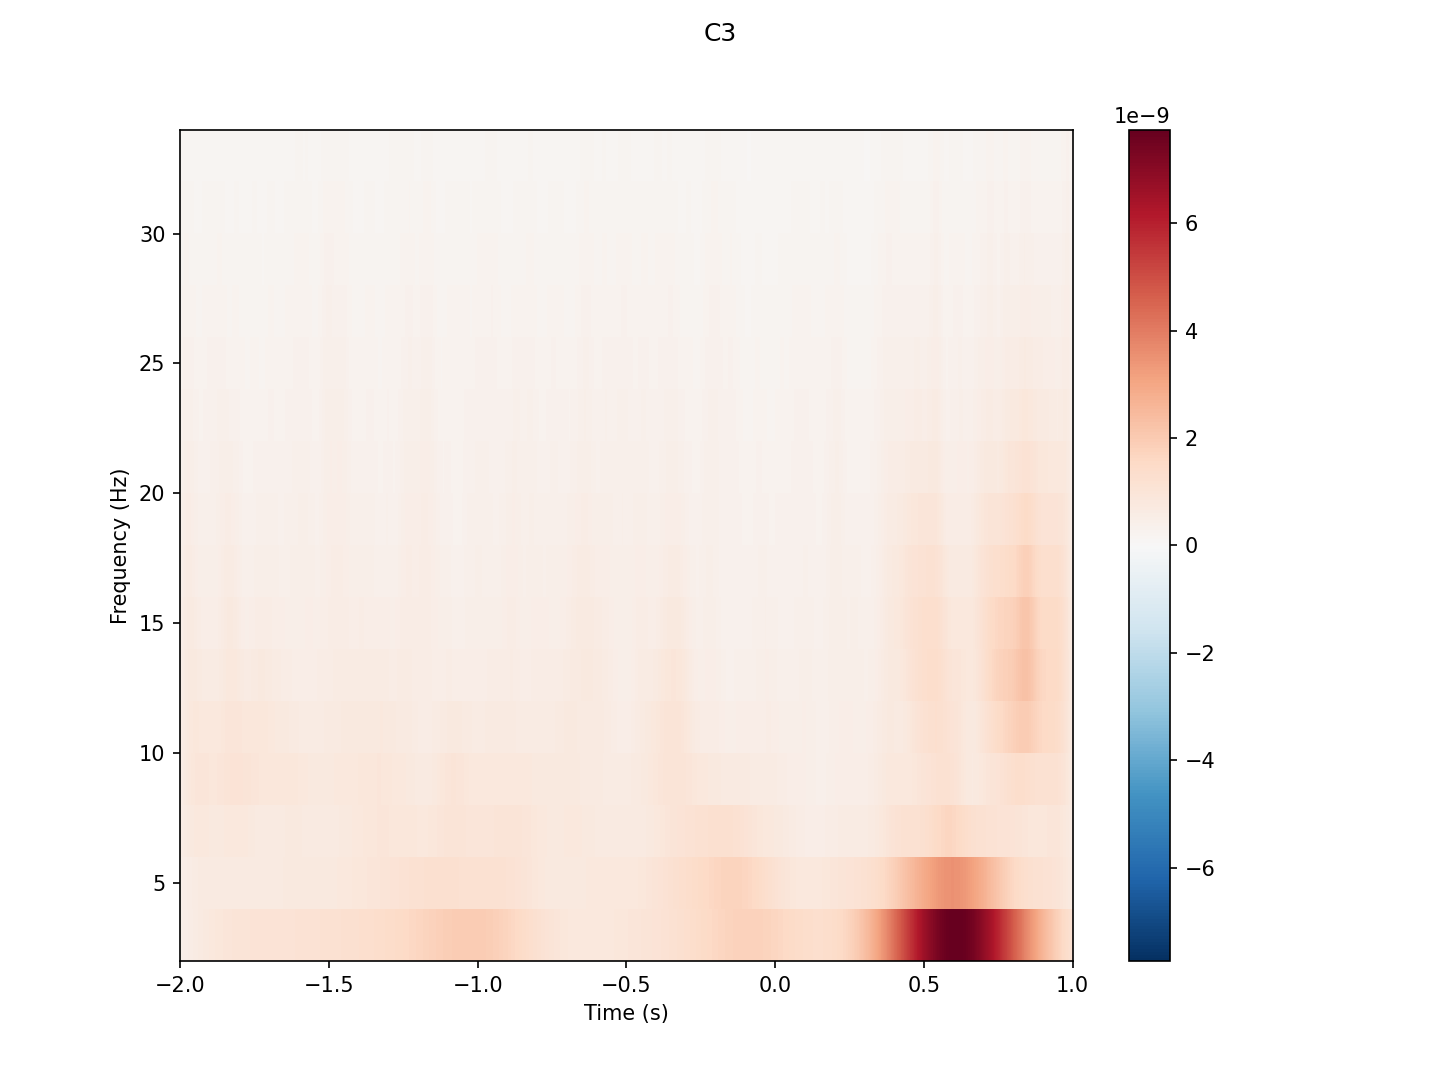

In [28]:
power.plot('C3')

No baseline correction applied


<IPython.core.display.Javascript object>


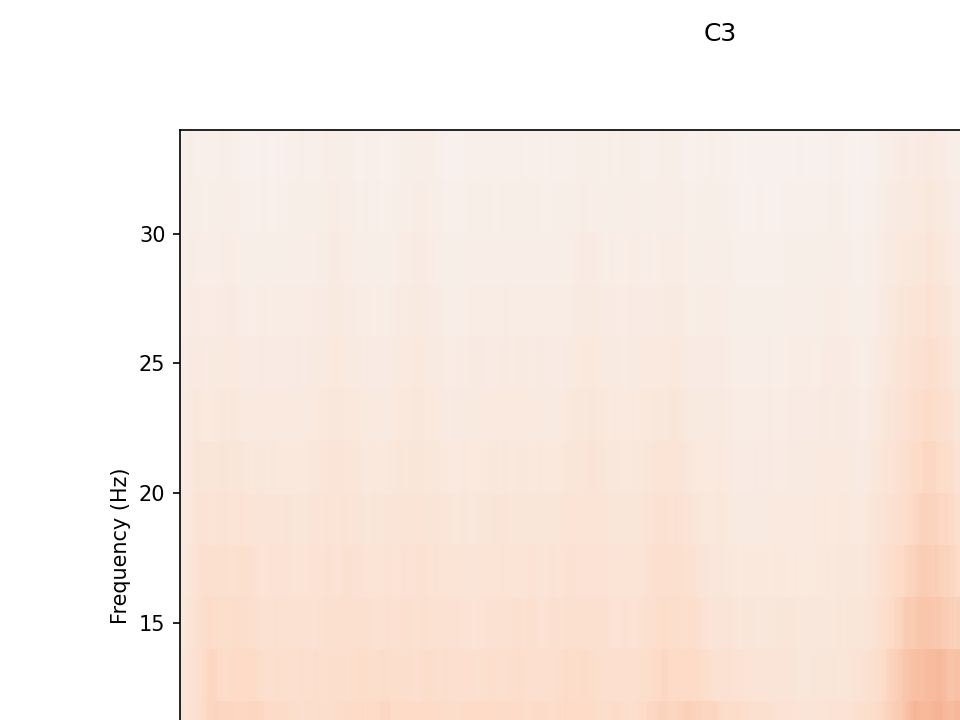

<IPython.core.display.Javascript object>


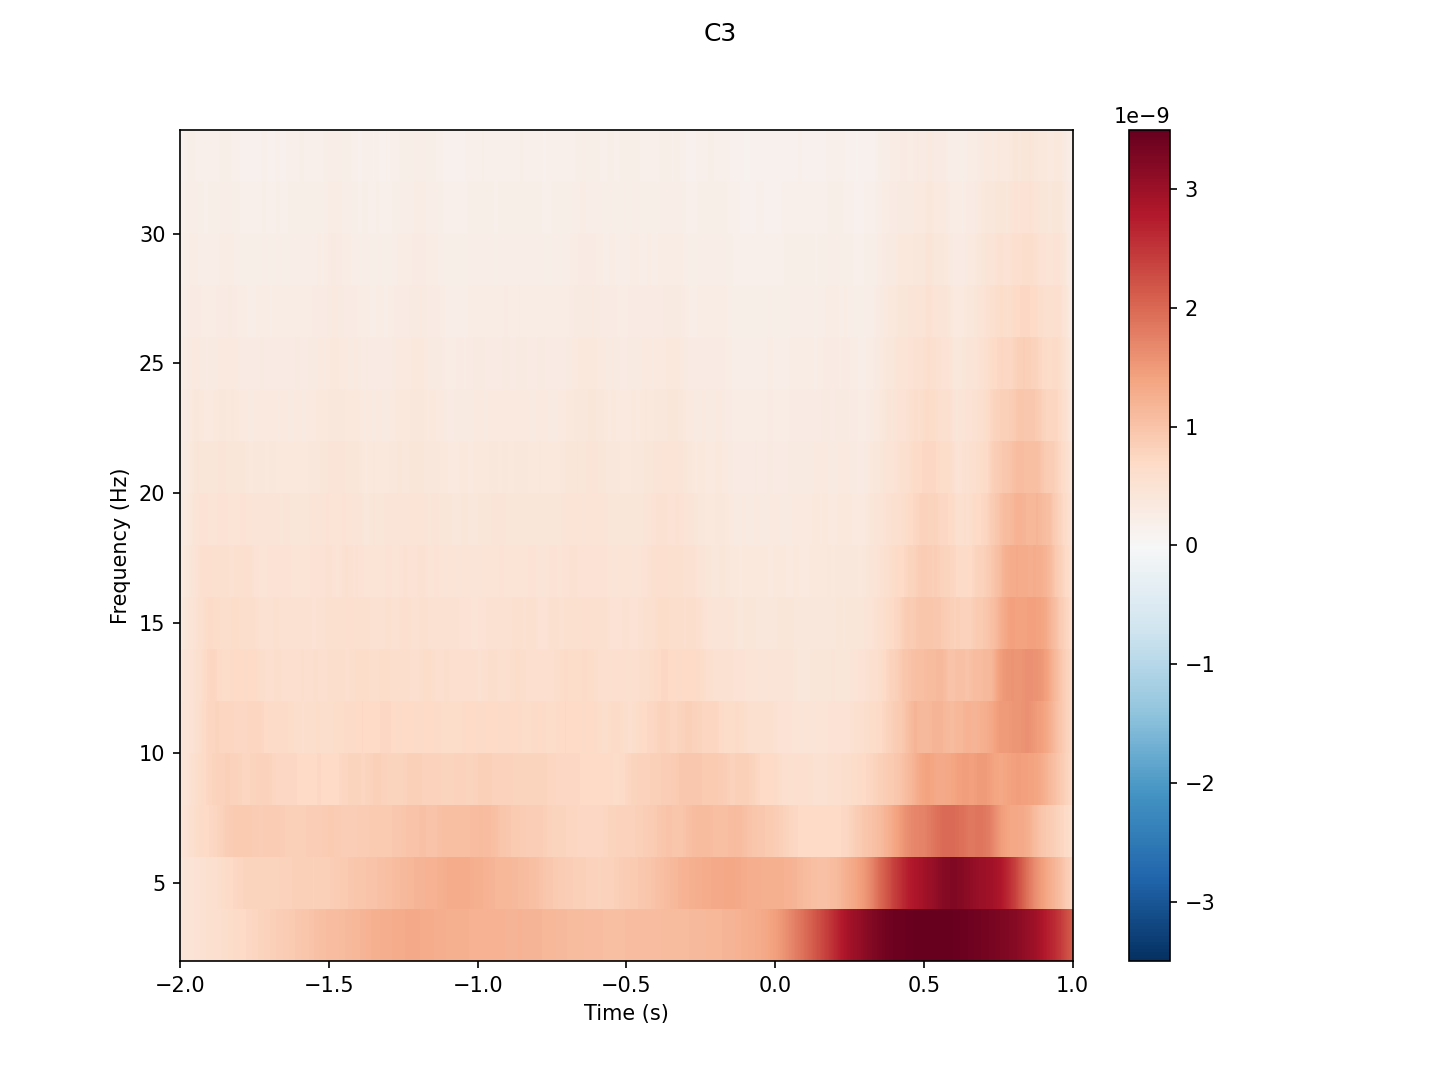

In [24]:
pw[0].plot('C3')

Now extract the alpha power, this is the one we are most interested in. Average the power in the frequency range 8-13Hz.

In [25]:
power_data=power.data
freq_ix=np.arange(2,5)
activity_alpha=np.mean(power_data[:,freq_ix,:],axis=1)

## Baseline normalization
### Change ratio
We remind the formula to compute change ratio: $$C_{tf}=\frac{\text{activity}_{tf}-\overline{baseline_{f}}}{\overline{baseline_{f}}} $$

Compute the ERSP using this formula, and plot the spectrogramm for channel C3.

Applying baseline correction (mode: percent)


<IPython.core.display.Javascript object>


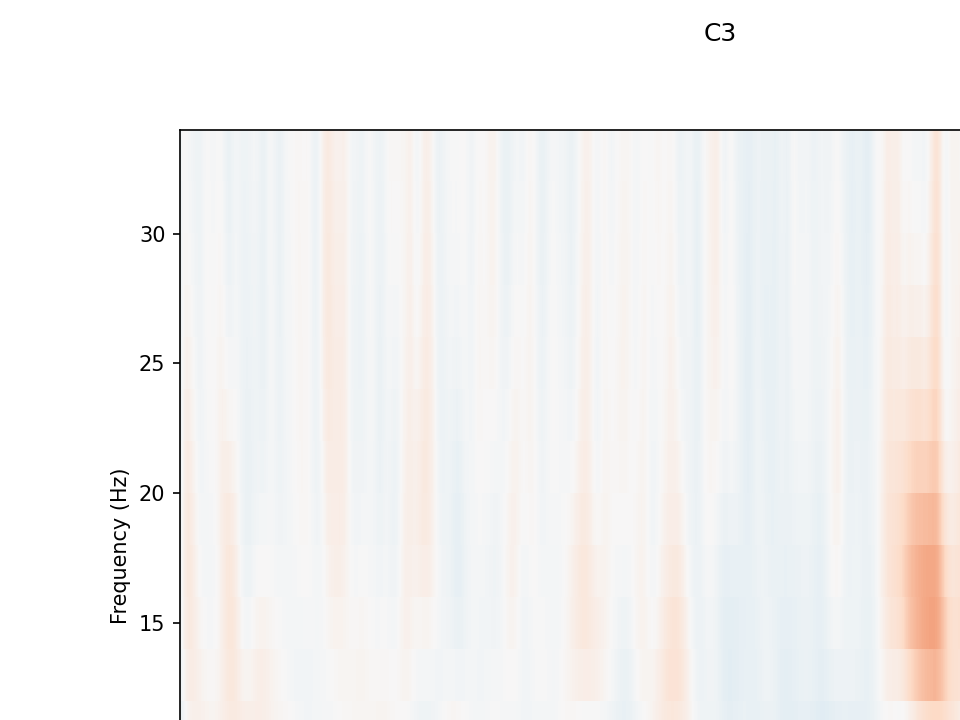

<IPython.core.display.Javascript object>


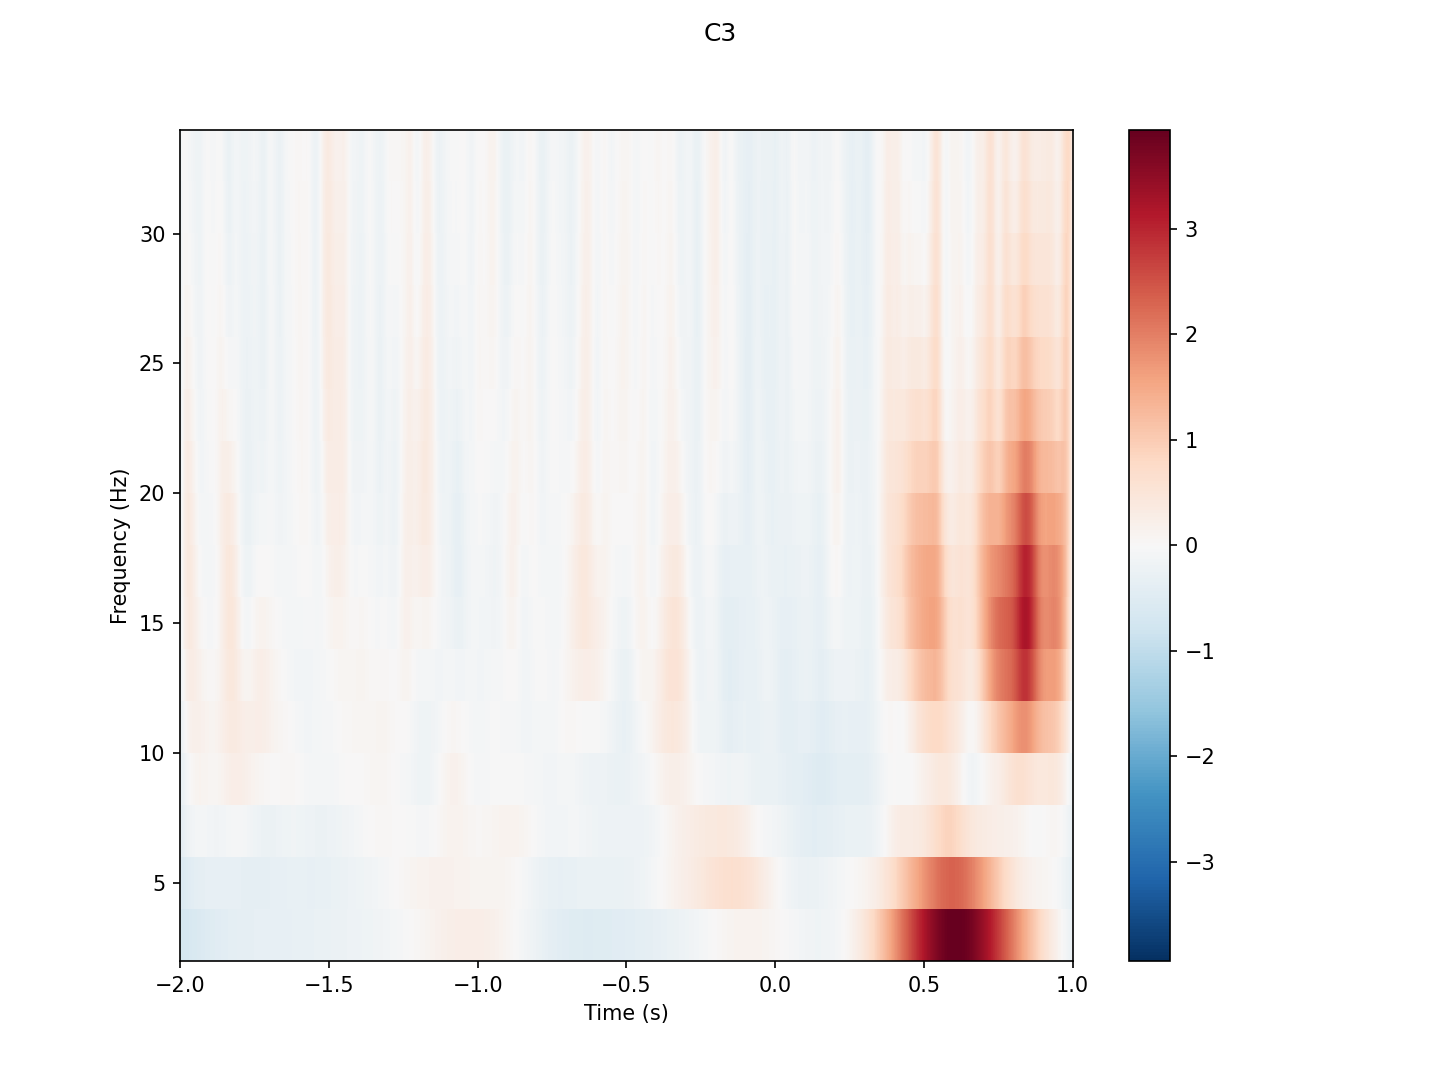

In [26]:
power.plot(picks='C3',baseline=(-1.5,-1.),mode='percent')

### Decibel deviation
We remind the formula to compute change ratio: $$dB_{tf}=10\log_{10}{\frac{\text{activity}_{tf}}{\overline{baseline_{f}}}}  $$

Compute the ERSP using this formula, and plot the spectrogramm for channel C3.

Applying baseline correction (mode: logratio)


<IPython.core.display.Javascript object>


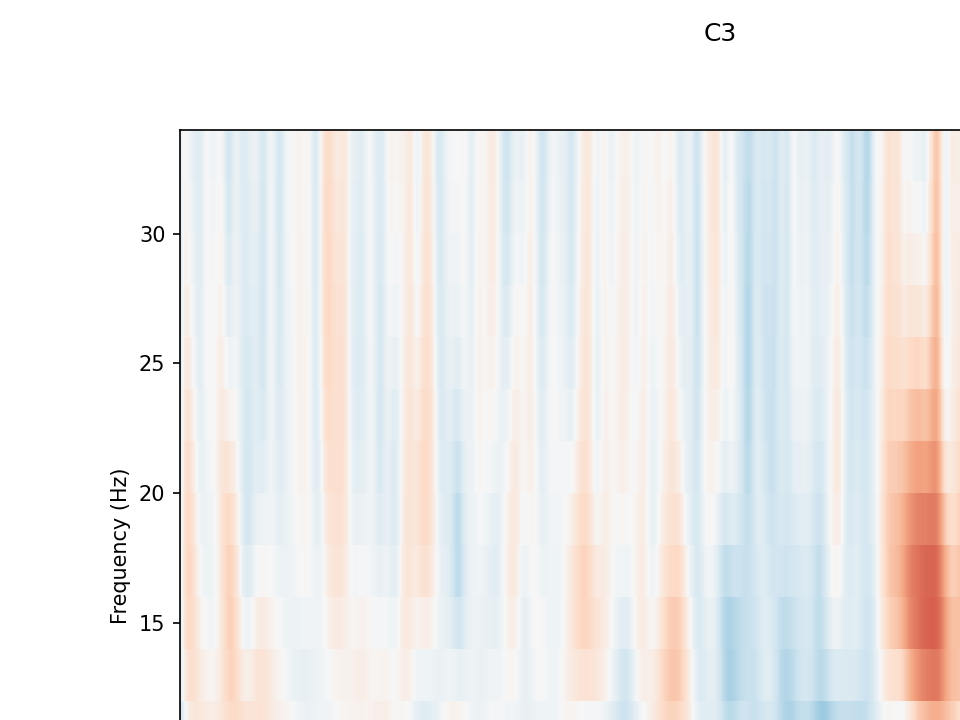

<IPython.core.display.Javascript object>


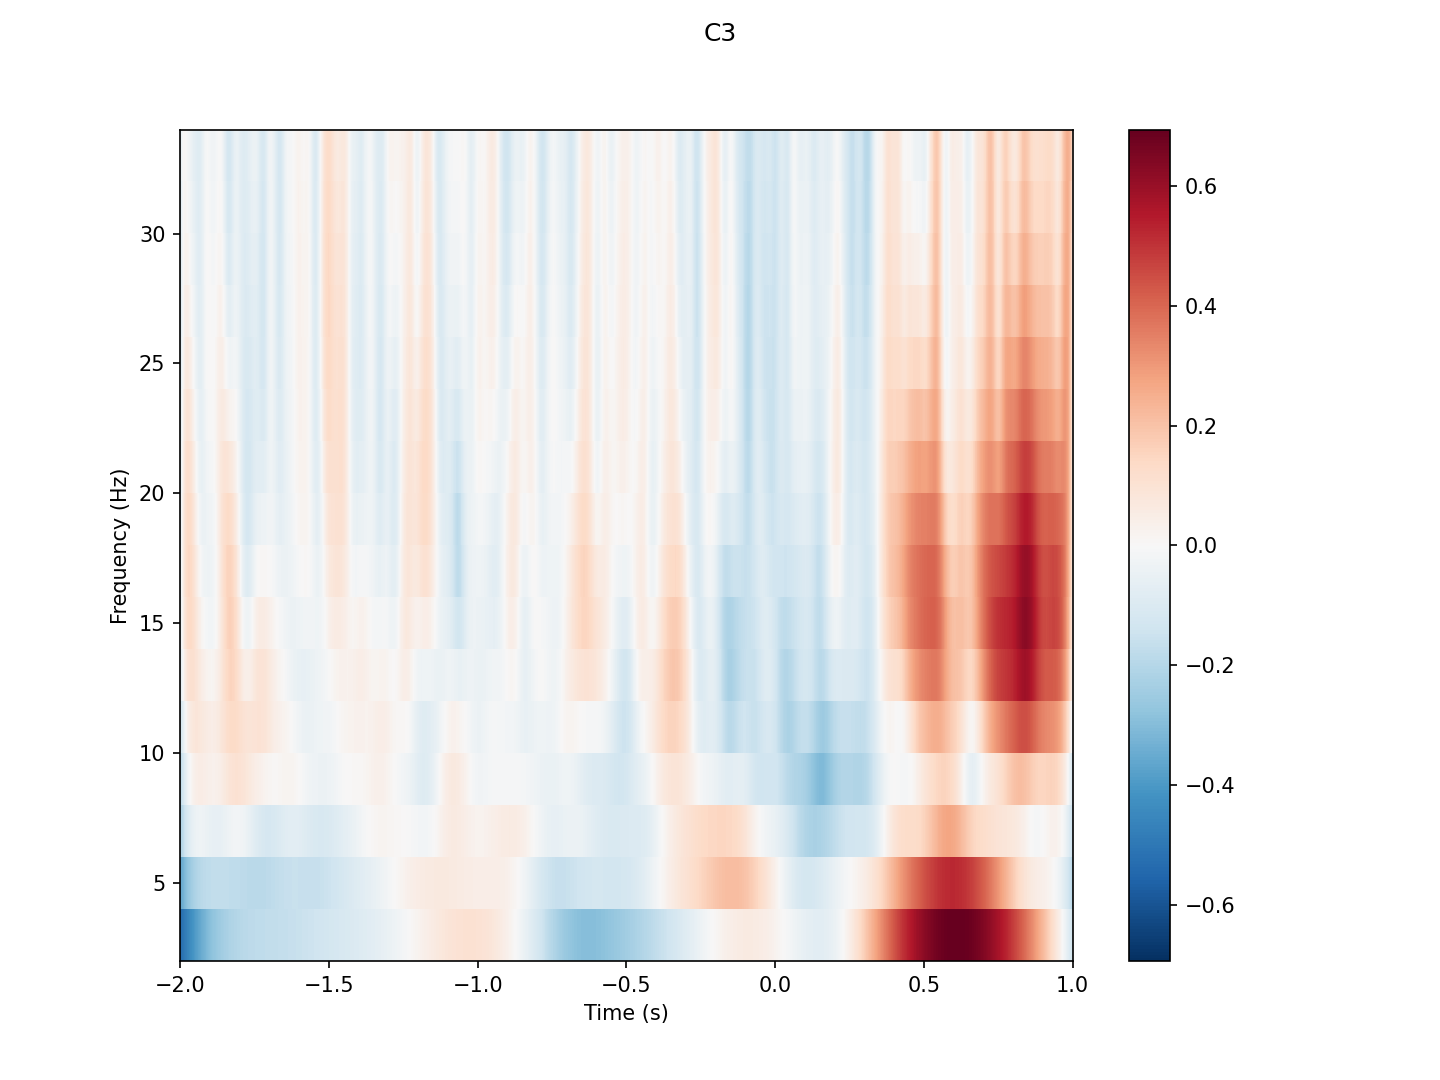

In [27]:
power.plot(picks='C3',baseline=(-1.5,-1.),mode='logratio')

Applying baseline correction (mode: logratio)


<IPython.core.display.Javascript object>


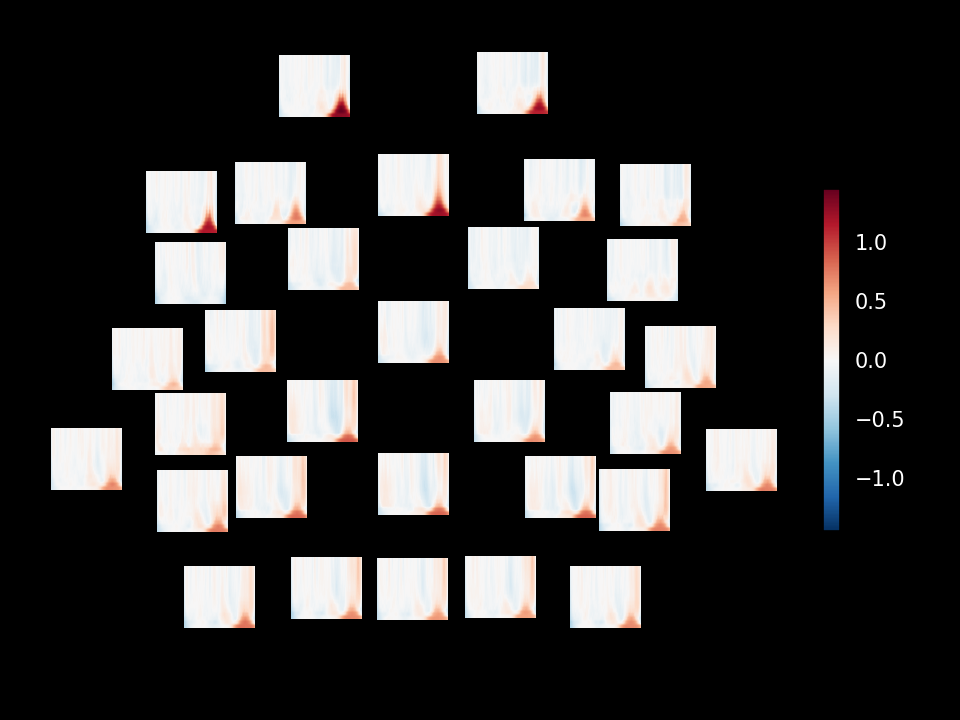

<IPython.core.display.Javascript object>


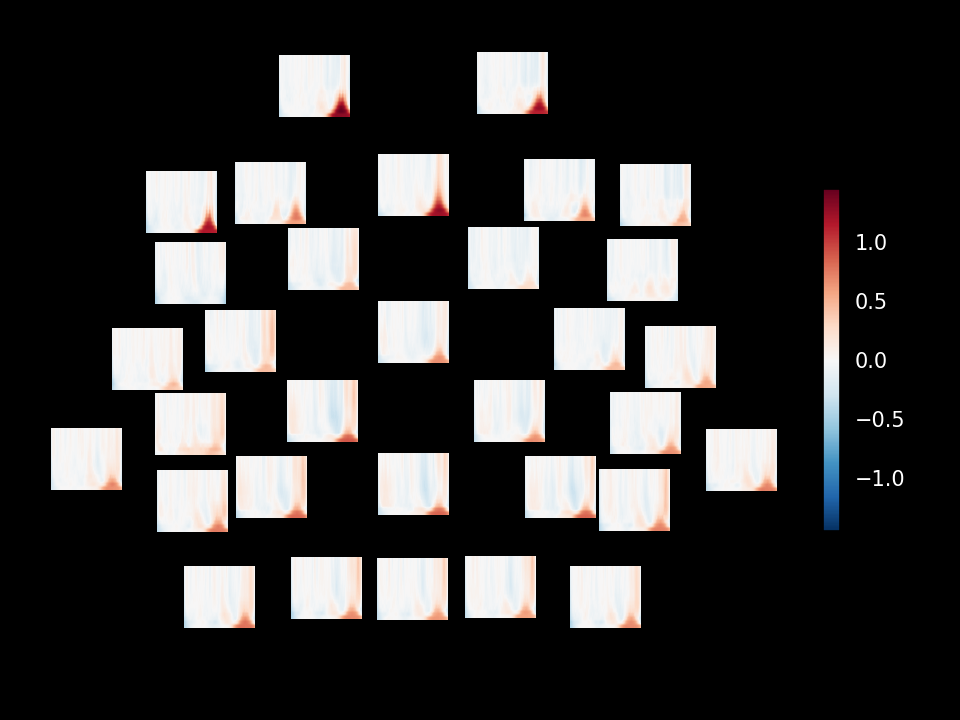

In [31]:
pw[0].plot_topo(baseline=(-1.5,-1.),mode='logratio')